In [73]:
import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install -U spacy
# !{sys.executable} -m pip install gensim
# !{sys.executable} -m spacy download en_core_web_sm
# !{sys.executable} -m pip install pyLDAvis
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install yellowbrick
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install dill

# !{sys.executable} -m pip install wordcloud

In [72]:
# Run in python console
import re
import os
import numpy as np
import pandas as pd
import random
import dill

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
import nltk; nltk.download('stopwords')
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import CVScores

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Understanding how listing description influence price and listing rating

The AirBnb dataset provides with features not only that have numeric or structured values but also unstructured data. To mention a few examples: the name of of the property, a short description of the space, an overview of the neighborhood and a description of the listing itself. As part of our project we would like to use Natural Language Processing techniques to understand how unstructured data available for each listing might influence price.

The reason we believe that there might be a relationship betweeen the listing description and the price is because 
we think that what makes a listing valuable is not only their features per se but also the way the place is presented to the potential guest. This, not only includes the pictures of the listing but also the words that the listing owners pick to describe their listing and assumingly seeks to attrack their potential customers. We assume that by including certain words in the description could potentially increase the attractiveness of a certain property to be rented. Thus, due to supply and demand law, can assume that the more demanded a property is, the higher the value it could have. 

To begin with the analysis we want to see if there are similarities in the way listing owners describe their place and the price they charge per night. We proceed with the assumption that listings with similar features will use similar words to describe their property. Furthermore we are curious about how words in the description could inform us about the listing's overall rating.

For this reason we will be using this notebook to try to answer the following questions:

1. Do listings using similar words in their description share a similar price?
2. Do listings using similar words in their description share other features that are relevant to predict price?
3. Do listings using similar words in their description end up having similar guest acceptance/rating?

For this purpose we will first, use Latent Dirichlet Allocation to elicit the latent topics in the description. Latent Dirichlet Allocation is an unsupervised algorithm, largely used in Natural Language Processing to perform what is known as Topic Modeling. This algorightm uses probability distribution to discover which parts of the data are similar. In the context of our project we would try to discover the similar words used the description of New York City listings that could potentially influence price.

## Importing data into DataFrame

In [9]:
path = '../data/new-york-city-airbnb-open-data/'
listings_csv = os.path.join(path,'listings.csv')

listings_df =  pd.read_csv(listings_csv,low_memory=False)

In [10]:
# Creating content column with name and description of property
listings_df['content'] = listings_df['name'] + listings_df['description']
content = listings_df[['id','content']]

As we will be able to see, the description is the single text field with fewer than 3% missing values. This is also one of the reasons why we chose to work with this field to experiment with NLP into trying to predict price.

In [11]:
summary_nulls = round((listings_df.summary.isnull().sum()/listings_df.shape[0])*100, 1)
space = round((listings_df.space.isnull().sum()/listings_df.shape[0])*100, 1)
description = round((listings_df.description.isnull().sum()/listings_df.shape[0])*100, 1)
neighborhood_overview = round((listings_df.neighborhood_overview.isnull().sum()/listings_df.shape[0])*100, 1)
notes = round((listings_df.notes.isnull().sum()/listings_df.shape[0])*100, 1)
transit = round((listings_df.transit.isnull().sum()/listings_df.shape[0])*100, 1)
access = round((listings_df.access.isnull().sum()/listings_df.shape[0])*100, 1)
interaction = round((listings_df.interaction.isnull().sum()/listings_df.shape[0])*100, 1)
house_rules = round((listings_df.house_rules.isnull().sum()/listings_df.shape[0])*100, 1)
name = round((listings_df.name.isnull().sum()/listings_df.shape[0])*100, 1)

In [12]:
print(f"{summary_nulls}% of listings have empty summaries")
print(f"{space}% of listings have empty space description")
print(f"{description}% of listings have empty description")
print(f"{neighborhood_overview}% of listings have empty overviews on their neighborhood")
print(f"{notes}% of listings have no notes from the host")
print(f"{transit}% of listings have no information on transit")
print(f"{access}% of listings have no information on accessibility")
print(f"{interaction}% of listings have no information on interaction")
print(f"{house_rules}% of listings have no information on house_rules")
print(f"{name}% of listings have no information on house_rules")

4.8% of listings have empty summaries
28.0% of listings have empty space description
2.4% of listings have empty description
34.4% of listings have empty overviews on their neighborhood
59.6% of listings have no notes from the host
34.4% of listings have no information on transit
47.2% of listings have no information on accessibility
40.2% of listings have no information on interaction
39.1% of listings have no information on house_rules
0.0% of listings have no information on house_rules


Importing numeric features from previous Exploratory Data Analysis and Modeling

In [13]:
# Importing model df
model_cols_df = pd.read_csv('../data/new-york-city-airbnb-open-data/model_columns_listings.csv',index_col = 0)

In [14]:
model_cols_df.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


In [15]:
# Joining the new created 'content' column with the model dataframe just to choose rows that are relevant
df_model = pd.merge(left=model_cols_df, right=content, how='left', on='id')

# dropping null values
df_model = df_model.dropna()

In [16]:
df_model.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## Predicting Language from content

As we may already know, AirBnb is a platform used by people from all around the world. Therefore, some hosts that want to attract guests who speak languages other than English might want to use different language or languages to describe their place. For our analysis we want to make sure that we are working with a single language and since the majority of reviews are written in English, we will use langdetect, to determine those descriptions written in English only. Langdetect is a language detection algorithm that supports 55 languages out of the box. To maximize the probability of the algorithms predicting the correct language we make sure we send it a long enough string.

In [17]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [18]:
df_model['content_lang'] = df_model.content.apply(lambda x: predict_lang(x))

In [19]:
# getting only text in English
df_model_en_desc = df_model[df_model.content_lang=='en']

In [20]:
df_model.shape, df_model_en_desc.shape

((27354, 47), (27105, 47))

In [21]:
df_model_en_desc.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## LDA for Topic Modeling in Listing Description

In [22]:
def generate_list_content(df):
#     df['content'] = df['name'] + df['summary']
#     df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [23]:
lst_texts = generate_list_content(df_model_en_desc)

In [24]:
len(lst_texts)

27105

## Tokenize words and clean up text

In [25]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [27]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [28]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [29]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

The biggest challenge of using LDA for Topic Modeling is determining the right amount of topics *n*. Therefore we will use two metrics: Perplexity and Coherence as well as the pyLDAvis to approximately determine the right number of topics that are latent in our corpus (description).

## Build list of topic models

In [30]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

# num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
num_topics = [2,3,4,5,6,7,8,9,10]
models = build_topics(num_topics)

In [31]:
## Saving the models to disc
from gensim.test.utils import datapath

# Save model to disk.
for i in range(len(models)):
    temp_file = datapath("model" + str(i))
    models[i].save(temp_file)

In [32]:
# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

## Compute Model Perplexity and Coherence Score for all models

According to (Jansen, 2018) "Perplexity when applied to LDA meassures how well the topic-word probability distribution recovered by the model predicts a sample, for example, unseen text documents. It is based on the entropy H(p) of this distribution p and computed with respect to the set of tokens w. Measures closer to zero imply the distribution is better at predicting the sample".

In terms of Coherence, we will be using Gensim implementation based on the paper writen by (Roder, et al., 2015). Larger scores in coherence mean better topic representation of the corpus.

## Bibliography

Jansen, S. (2018). Perplexity. In Hands-on machine learning for algorithmic trading: Design and implement investment strategies based on smart algorithms that learn from data using Python. Birmingham: Packt Publishing.

Roder, M., Both, A., and Hinneburg, A. (2015). Exploring the Space of Topic Coherence Measures. In Proceedings of the Eighth ACM International Conference on Web Search and Data Mining, WSDM ’15, pages 399–408, New York, NY, USA. ACM.

In [33]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [34]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.710349,0.434397,2
1,-6.698073,0.472094,3
2,-6.708062,0.484920,4
3,-6.723129,0.548987,5
4,-6.740764,0.457324,6
5,-6.766024,0.455074,7
6,-6.797780,0.388430,8
7,-6.848104,0.494176,9
8,-6.943929,0.430461,10


## Graphic of number of Topics and Perplexity

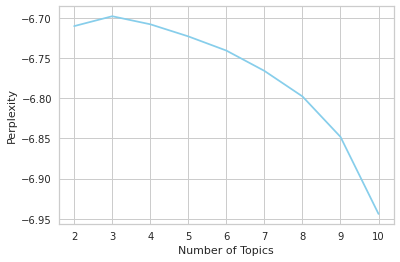

In [35]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

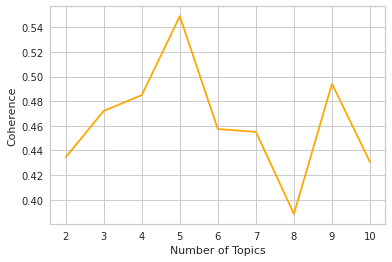

In [36]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Visualizing topics according to the best *n*

### Visualization with 5 topics

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(models[3], corpus, id2word, sort_topics=False)
vis_5

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       2.000987        1       1  0.248399  0.285994
1      34.600704        1       2 -0.203257  0.039852
2      30.802662        1       3 -0.215553 -0.110286
3       2.099020        1       4  0.322206 -0.251970
4      30.496628        1       5 -0.151795  0.036409, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
289   Default  12704.000000          stay  12704.000000  30.0000  30.0000
99    Default  40615.000000          room  40615.000000  29.0000  29.0000
141   Default  19812.000000          walk  19812.000000  28.0000  28.0000
106   Default  19326.000000         train  19326.000000  27.0000  27.0000
8     Default  20669.000000           bed  20669.000000  26.0000  26.0000
185   Default  15933.000000         space  15933.000000  25.0000  25.0000
93    Default  18159.000000        minute  18159.000000  24.0000  24.0000
218   Default  17086.000000    restaurant  17086.000000  23.0000  23.0000
87    Default  16516.000000         guest  16516.000000  22.0000  22.0000
63    Default  29459.000000       bedroom  29459.000000  21.0000  21.0000
198   Default  14399.000000          away  14399.000000  20.0000  20.0000
64    Default  11823.000000         block  11823.000000  19.0000  19.0000
110   Default  45229.000000     apartment  45229.000000  18.0000  18.0000
20    Default  13147.000000          full  13147.000000  17.0000  17.0000
201   Default   4003.000000         check   4003.000000  16.0000  16.0000
137   Default  11194.000000        subway  11194.000000  15.0000  15.0000
239   Default   6840.000000         fully   6840.000000  14.0000  14.0000
182   Default  10273.000000         share  10273.000000  13.0000  13.0000
202   Default  10404.000000         close  10404.000000  12.0000  12.0000
19    Default  11510.000000         floor  11510.000000  11.0000  11.0000
309   Default  12055.000000          home  12055.000000  10.0000  10.0000
249   Default  12837.000000  neighborhood  12837.000000   9.0000   9.0000
236   Default   5280.000000         equip   5280.000000   8.0000   8.0000
228   Default   9769.000000           bar   9769.000000   7.0000   7.0000
55    Default   5008.000000         towel   5008.000000   6.0000   6.0000
366   Default   8339.000000         clean   8339.000000   5.0000   5.0000
136   Default   7989.000000       station   7989.000000   4.0000   4.0000
29    Default   8653.000000         large   8653.000000   3.0000   3.0000
500   Default   3169.000000          text   3169.000000   2.0000   2.0000
131   Default   8574.000000         queen   8574.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
794    Topic5   1232.549805          rest   1233.394897   1.1869  -6.0928
1176   Topic5   1172.969360          lock   1173.816284   1.1868  -6.1424
494    Topic5   1180.119385           let   1180.973145   1.1868  -6.1363
32     Topic5   2328.789795          love   2330.584229   1.1868  -5.4566
595    Topic5   5481.091309          make   5489.047852   1.1861  -4.6006
368    Topic5   3674.593506           day   3689.166260   1.1836  -5.0005
108    Topic5   5807.038086           use   5934.734863   1.1658  -4.5428
309    Topic5  11354.252930          home  12055.120117   1.1277  -3.8723
492    Topic5   4706.687012          free   4936.294922   1.1399  -4.7529
289    Topic5  11193.356445          stay  12704.222656   1.0609  -3.8866
94     Topic5   8898.713867          need  10106.713867   1.0603  -4.1160
99     Topic5  29984.505859          room  40615.414062   0.8841  -2.9012
130    Topic5   3437.707275        people   3758.357178   1.0984  -5.0671
548    Topic5   2211.097168          look   2280.270264   1.1567  -5.5084
139    Topic5   6592.119141          time   8110.956055   0.9802  -4.4160
175    Topic5   7687.193848

In [38]:
pyLDAvis.save_html(vis_5, '../data/visualization_5_topics.html')

### Visualization with 7 topics

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_7 = pyLDAvis.gensim.prepare(models[5], corpus, id2word, sort_topics=False)
vis_7

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       1.138856        1       1 -0.264359 -0.133872
1      24.661156        1       2  0.234970 -0.022311
2      11.961952        1       3  0.137848 -0.134864
3       1.427352        1       4 -0.259953 -0.128009
4      27.293619        1       5  0.167651 -0.103961
5      30.789787        1       6  0.185002  0.201485
6       2.727282        1       7 -0.201159  0.321534, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
289   Default  12757.000000            stay  12757.000000  30.0000  30.0000
8     Default  19788.000000             bed  19788.000000  29.0000  29.0000
99    Default  40243.000000            room  40243.000000  28.0000  28.0000
110   Default  43799.000000       apartment  43799.000000  27.0000  27.0000
141   Default  20127.000000            walk  20127.000000  26.0000  26.0000
63    Default  28329.000000         bedroom  28329.000000  25.0000  25.0000
19    Default  12117.000000           floor  12117.000000  24.0000  24.0000
106   Default  19634.000000           train  19634.000000  23.0000  23.0000
114   Default   6247.000000             bus   6247.000000  22.0000  22.0000
93    Default  18449.000000          minute  18449.000000  21.0000  21.0000
87    Default  16447.000000           guest  16447.000000  20.0000  20.0000
218   Default  17358.000000      restaurant  17358.000000  19.0000  19.0000
20    Default  12587.000000            full  12587.000000  18.0000  18.0000
198   Default  14629.000000            away  14629.000000  17.0000  17.0000
345   Default   4424.000000             min   4424.000000  16.0000  16.0000
96    Default  20297.000000         private  20297.000000  15.0000  15.0000
201   Default   4116.000000           check   4116.000000  14.0000  14.0000
64    Default  12011.000000           block  12011.000000  13.0000  13.0000
249   Default  13004.000000    neighborhood  13004.000000  12.0000  12.0000
136   Default   8133.000000         station   8133.000000  11.0000  11.0000
137   Default  11372.000000          subway  11372.000000  10.0000  10.0000
309   Default  12591.000000            home  12591.000000   9.0000   9.0000
182   Default  10230.000000           share  10230.000000   8.0000   8.0000
202   Default  10569.000000           close  10569.000000   7.0000   7.0000
185   Default  16083.000000           space  16083.000000   6.0000   6.0000
28    Default  11645.000000         kitchen  11645.000000   5.0000   5.0000
228   Default   9924.000000             bar   9924.000000   4.0000   4.0000
134   Default   7759.000000            size   7759.000000   3.0000   3.0000
131   Default   8205.000000           queen   8205.000000   2.0000   2.0000
29    Default   8312.000000           large   8312.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
1570   Topic7    511.131348            taxi    512.061218   3.6000  -4.5587
1626   Topic7    478.660400            bank    479.590179   3.5999  -4.6244
1664   Topic7    439.422180         stocked    440.354095   3.5997  -4.7099
470    Topic7    406.435547         premise    407.366272   3.5996  -4.7879
1826   Topic7    380.272217        brooklyn    381.204987   3.5994  -4.8545
1477   Topic7    367.332916           point    368.264832   3.5993  -4.8891
1171   Topic7    366.543091         cabinet    367.475800   3.5993  -4.8912
2732   Topic7    355.815277         college    356.745758   3.5993  -4.9209
801    Topic7    301.827820         cuisine    302.757660   3.5988  -5.0855
1777   Topic7    297.241241         various    298.170685   3.5987  -5.1008
2927   Topic7    273.762970          bakery    274.693604   3.5985  -5.1831
1924   Topic7    262.879364            mini    263.812073   3.5983  -5.2237
1828   Topic7    256.937805       equipment    257.

In [40]:
pyLDAvis.save_html(vis_7, '../data/visualization_7_topics.html')

### Visualization with 9 topics 

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_9 = pyLDAvis.gensim.prepare(models[7], corpus, id2word, sort_topics=False)
vis_9

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       1.058751        1       1  0.266562  0.011325
1      20.682045        1       2 -0.180487  0.151577
2       8.502641        1       3 -0.028717  0.199761
3       1.251002        1       4  0.268364 -0.003164
4      25.407261        1       5 -0.142769  0.035538
5      11.153189        1       6 -0.133484  0.139688
6       3.256708        1       7  0.205035  0.013662
7      20.916046        1       8 -0.216247 -0.173403
8       7.772362        1       9 -0.038256 -0.374984, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
96    Default  22361.000000       private  22361.000000  30.0000  30.0000
106   Default  19504.000000         train  19504.000000  29.0000  29.0000
93    Default  18327.000000        minute  18327.000000  28.0000  28.0000
63    Default  29197.000000       bedroom  29197.000000  27.0000  27.0000
110   Default  44685.000000     apartment  44685.000000  26.0000  26.0000
141   Default  20200.000000          walk  20200.000000  25.0000  25.0000
99    Default  40930.000000          room  40930.000000  24.0000  24.0000
8     Default  20069.000000           bed  20069.000000  23.0000  23.0000
19    Default  12243.000000         floor  12243.000000  22.0000  22.0000
218   Default  17565.000000    restaurant  17565.000000  21.0000  21.0000
198   Default  14658.000000          away  14658.000000  20.0000  20.0000
87    Default  16487.000000         guest  16487.000000  19.0000  19.0000
136   Default   8064.000000       station   8064.000000  18.0000  18.0000
249   Default  13134.000000  neighborhood  13134.000000  17.0000  17.0000
20    Default  12766.000000          full  12766.000000  16.0000  16.0000
64    Default  12155.000000         block  12155.000000  15.0000  15.0000
117   Default   7149.000000        coffee   7149.000000  14.0000  14.0000
381   Default   5464.000000       provide   5464.000000  13.0000  13.0000
28    Default  11901.000000       kitchen  11901.000000  12.0000  12.0000
137   Default  11508.000000        subway  11508.000000  11.0000  11.0000
289   Default  12816.000000          stay  12816.000000  10.0000  10.0000
127   Default  10547.000000        living  10547.000000   9.0000   9.0000
201   Default   4117.000000         check   4117.000000   8.0000   8.0000
239   Default   6697.000000         fully   6697.000000   7.0000   7.0000
228   Default  10043.000000           bar  10043.000000   6.0000   6.0000
366   Default   8268.000000         clean   8268.000000   5.0000   5.0000
31    Default  14692.000000        locate  14692.000000   4.0000   4.0000
114   Default   6041.000000           bus   6041.000000   3.0000   3.0000
55    Default   4446.000000         towel   4446.000000   2.0000   2.0000
182   Default  10255.000000         share  10255.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
2053   Topic9    394.313477    everywhere    395.277161   2.5522  -5.8655
470    Topic9    392.970367       premise    393.933990   2.5521  -5.8689
1837   Topic9    365.030334         staff    365.995361   2.5520  -5.9426
2578   Topic9    346.753662        pickup    347.721252   2.5518  -5.9940
812    Topic9    302.856567          type    303.820190   2.5514  -6.1294
2555   Topic9    293.201324    definitely    294.165131   2.5513  -6.1618
801    Topic9    291.845978       cuisine    292.809387   2.5513  -6.1664
1385   Topic9    291.248138        change    292.212067   2.5513  -6.1684
4634   Topic9    273.770355     socialize    274.734283   2.5511  -6.2303
713    Topic9    260.740265       library    261.703949   2.5509  -6.2791
1381   Topic9    240.069687          pool    241.033615   2.5506  -6.3617
1604   Topic9    236.428757           cab    237.392120   2.5505  -6.3770
1905   Topic9    198.188934      

In [42]:
pyLDAvis.save_html(vis_9, '../data/visualization_9_topics.html')

## Creating DataFrame with scores and topics for 5 topics

In [43]:
# function that returns data frame with 
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()
#     df_model_en_desc.reset_index(inplace=True)
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         print(row)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
    sent_topics_df = pd.concat([df_model_en_desc['id'],sent_topics_df], axis=1)
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [44]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[3], corpus=corpus, texts=lst_texts)

In [45]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5
0,2595.0,"(1, 0.85685253)","(2, 0.07285734)","(4, 0.065015435)",None,None
1,3831.0,"(1, 0.62045664)","(2, 0.19797744)","(4, 0.17561293)",None,None
2,5099.0,"(1, 0.57868826)","(2, 0.2812813)","(4, 0.13499214)",None,None
3,5121.0,"(4, 0.43239775)","(0, 0.2049708)","(3, 0.16388075)","(2, 0.10912616)","(1, 0.0896245)"
4,5178.0,"(1, 0.424061)","(4, 0.3113512)","(2, 0.19707568)","(3, 0.043394182)","(0, 0.024117941)"


In [46]:
sent_topics_df.shape

(27856, 6)

In [47]:
sent_topics_df = sent_topics_df.dropna()

In [48]:
sent_topics_df.shape

(5801, 6)

### Separating the Topic from its score

In [49]:
for i in range(1,df_n_cols):
    top_col = 'topic' + str(i)
    score_col = 'score_dom_topic_' + str(i)
    sent_topics_df[top_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[0]
    sent_topics_df[score_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [50]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
3,5121.0,"(4, 0.43239775)","(0, 0.2049708)","(3, 0.16388075)","(2, 0.10912616)","(1, 0.0896245)",4,0.432398,0,0.204971,3,0.163881,2,0.109126,1,0.089625
4,5178.0,"(1, 0.424061)","(4, 0.3113512)","(2, 0.19707568)","(3, 0.043394182)","(0, 0.024117941)",1,0.424061,4,0.311351,2,0.197076,3,0.043394,0,0.024118
15,8490.0,"(1, 0.55009234)","(4, 0.31815943)","(2, 0.09039322)","(0, 0.027603768)","(3, 0.013751306)",1,0.550092,4,0.318159,2,0.090393,0,0.027604,3,0.013751
20,10452.0,"(1, 0.4562522)","(4, 0.24804632)","(2, 0.23019294)","(0, 0.045224108)","(3, 0.020284474)",1,0.456252,4,0.248046,2,0.230193,0,0.045224,3,0.020284
37,14468.0,"(2, 0.4930517)","(1, 0.2515223)","(4, 0.2127166)","(0, 0.027537484)","(3, 0.015171946)",2,0.493052,1,0.251522,4,0.212717,0,0.027537,3,0.015172


In [51]:
# Dropping columns with tuples
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [52]:
sent_topics_df.head()

,id,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
3,5121.0,4,0.432398,0,0.204971,3,0.163881,2,0.109126,1,0.089625
4,5178.0,1,0.424061,4,0.311351,2,0.197076,3,0.043394,0,0.024118
15,8490.0,1,0.550092,4,0.318159,2,0.090393,0,0.027604,3,0.013751
20,10452.0,1,0.456252,4,0.248046,2,0.230193,0,0.045224,3,0.020284
37,14468.0,2,0.493052,1,0.251522,4,0.212717,0,0.027537,3,0.015172


In [53]:
# Formatting DataFrame
sent_topics_df.rename(columns={"topic1": "winner_topic",
                               "score_dom_topic_1":"winner_topic_score",
                               "topic2": "second_place_topic",
                               "score_dom_topic_2":"second_topic_score",
                               "topic3": "third_place_topic",
                               "score_dom_topic_3":"third_topic_score",
                               "topic4": "fourth_place_topic",
                               "score_dom_topic_4":"fourth_topic_score",
                              "topic5": "fifth_place_topic",
                               "score_dom_topic_5":"fifth_topic_score"},inplace=True)

In [54]:
sent_topics_df.head()

,id,winner_topic,winner_topic_score,second_place_topic,second_topic_score,third_place_topic,third_topic_score,fourth_place_topic,fourth_topic_score,fifth_place_topic,fifth_topic_score
3,5121.0,4,0.432398,0,0.204971,3,0.163881,2,0.109126,1,0.089625
4,5178.0,1,0.424061,4,0.311351,2,0.197076,3,0.043394,0,0.024118
15,8490.0,1,0.550092,4,0.318159,2,0.090393,0,0.027604,3,0.013751
20,10452.0,1,0.456252,4,0.248046,2,0.230193,0,0.045224,3,0.020284
37,14468.0,2,0.493052,1,0.251522,4,0.212717,0,0.027537,3,0.015172


## Modeling

In [55]:
# Merging the initial DataFrame with features with the topics DataFrame
df_model_en_desc_merged = pd.merge(left=df_model_en_desc, right=sent_topics_df, how='left', on='id')

In [56]:
df_model_en_desc_merged.iloc[:,0:6].head()

,id,host_since,host_is_superhost,host_identity_verified,is_location_exact,accommodates
0,2595,733294,0,1,0,2
1,3831,733383,0,1,1,3
2,5099,733440,0,0,0,2
3,5121,733441,0,0,0,2
4,5178,733469,0,0,1,2


In [57]:
df_model_en_desc_merged.shape

(27105, 57)

In [58]:
df_model_en_desc_merged = df_model_en_desc_merged.dropna()

In [59]:
df_model_en_desc_merged.shape

(5801, 57)

### Understanding the topic that appears as winner the most

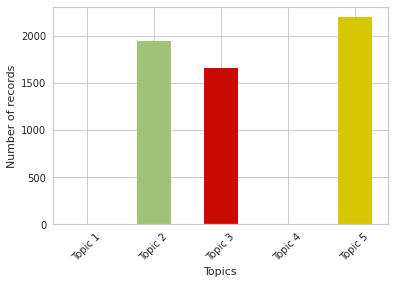

In [60]:
fig, ax = plt.subplots()
df = df_model_en_desc_merged.groupby('winner_topic').size().plot(kind='bar', x='topics', ax=ax)
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Topic 1'
labels[1] = 'Topic 2'
labels[2] = 'Topic 3'
labels[3] = 'Topic 4'
labels[4] = 'Topic 5'

ax.set_xticklabels(labels,rotation='45')
ax.set(xlabel='Topics', ylabel='Number of records')

plt.show()

The above plot si a representation of the distribution of the topics as the first option for each docuement.

at this plot we can conclude tha the topic that appear to be more latent in the corpus is the green bar that corresponds to topic 2 and the less prevalent is topic4. Let's now take a more thorough look at the words that are in each topic to have a better understanding of wht might be happening.

### Word Clouds

In [61]:
num_topics = 5
topic_words = []
for i in range(num_topics):
    tt = models[3].get_topic_terms(i,20)
    topic_words.append([id2word[pair[0]] for pair in tt])

In [62]:
models[3].show_topic(0)

[('stay', 0.04218512),
 ('space', 0.021580722),
 ('event', 0.021263458),
 ('artist', 0.02100554),
 ('text', 0.019222373),
 ('check', 0.018647177),
 ('sonder', 0.018589342),
 ('run', 0.01546441),
 ('design', 0.015090791),
 ('energy', 0.013643939)]

In [63]:
df_top_30_n_5 = pd.DataFrame.from_records(topic_words)
df_top_30_n_5 = df_top_30_n_5.T

In [64]:
df_top_30_n_5.rename(columns={0: "Topic 1", 1: "Topic 2",
                              2: "Topic 3", 3: "Topic 4",
                              4: "Topic 5"}, inplace=True)

In [65]:
df_top_30_n_5

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,stay,bedroom,walk,check,room
1,space,apartment,train,pm,guest
2,event,bed,apartment,read,home
3,artist,full,minute,show,stay
4,text,floor,restaurant,book,private
5,check,room,away,late,share
6,sonder,kitchen,neighborhood,fee,space
7,run,private,block,early,need
8,design,large,subway,listing,clean
9,energy,queen,close,list,place


In [66]:
top_0 = models[3].show_topic(0, 30)
top_1 = models[3].show_topic(1, 30)
top_2 = models[3].show_topic(2, 30)
top_3 = models[3].show_topic(3, 30)
top_4 = models[3].show_topic(4, 30)

In [67]:
def listtodict(A, di):
    di = dict(A)
    return di 

di_wc_0 = listtodict(top_0,{})
di_wc_1 = listtodict(top_1,{})
di_wc_2 = listtodict(top_2,{})
di_wc_3 = listtodict(top_3,{})
di_wc_4 = listtodict(top_4,{})

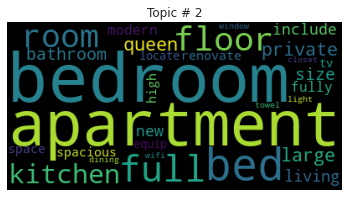

In [74]:
plt.figure()
plt.imshow(WordCloud().fit_words(di_wc_1))
plt.axis("off")
plt.title("Topic # 2")
plt.show()

It seems that Topic 2 has words related to location, for example: walk, train, neighborhood, block, close. This may lead to conclude that the majority of hosts recognize the importance of including such words into their description to attract guests. However, lets see if these words are actually influencing price. For this purpose we will try to understand the importance of each one of these topics' scores in our regression problem. We assume that the larger the impact of the score of each topic in the corpus, the most important to determine its price.

### Creating features X

In [75]:
X = df_model_en_desc_merged.iloc[:, 1:]
X = X.loc[:, X.columns != 'price']
X = X.loc[:, X.columns != 'content']
X = X.loc[:, X.columns != 'content_lang']

### Creating target y

In [76]:
y = df_model_en_desc_merged.price

### Cross validation with multiple regressors

In [77]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

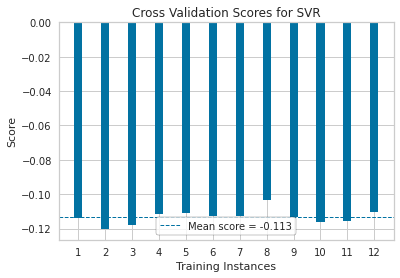

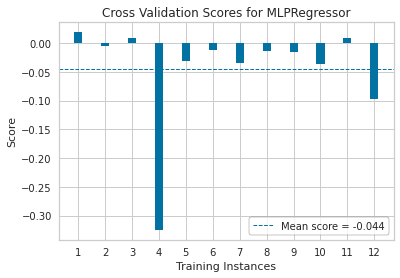

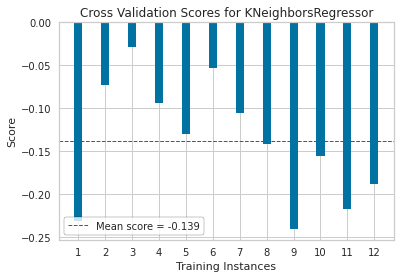

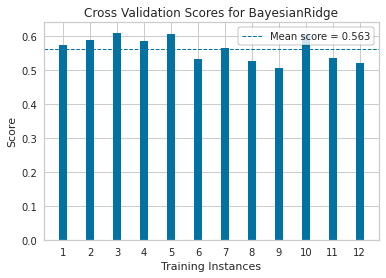

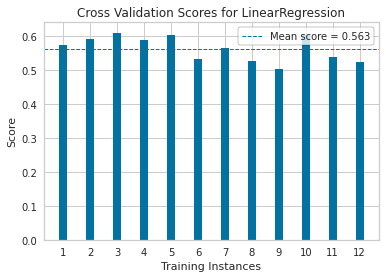

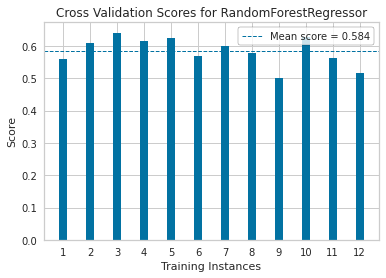

In [78]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = CVScores(regressor, cv=cv)
    visualizer.fit(X, y)
    visualizer.show()

## Residuals for multiple regression models

### Split train - test sets

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

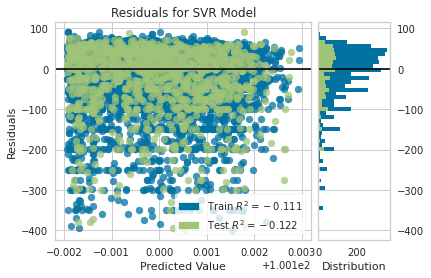

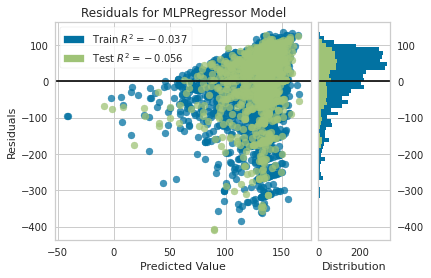

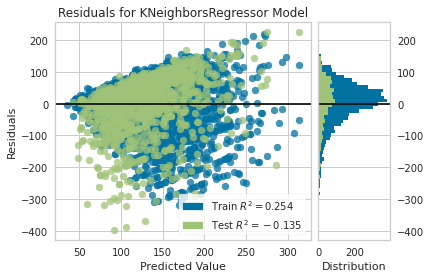

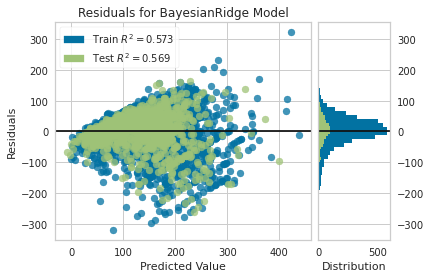

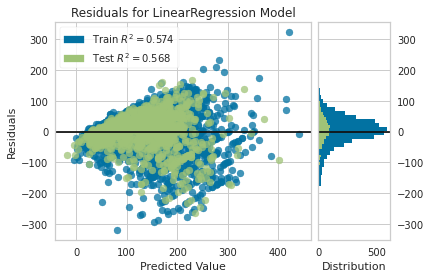

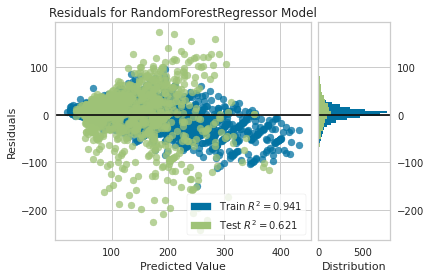

In [80]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

After analyzing the average score in cross validations together with the residuals, we can continue to conclude that our baseline model is still the Random Forest Regressor. This excercise was fundamental to see that despite the addition of information about the description, this continues to be true. We will now continue doing some more experimentation.

## Experimenting with the baseline model using the Random Forest Regressor

Random Forest algorithms are ensemble methods of decision trees generated on a random split of a determined data set.The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In the case of regression, the average of all the tree outputs is considered as the final result. Source: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [81]:
# Creating a list of features to use as labels in FeatureImportances
features=list()

for col in df_model_en_desc_merged.columns:
    features.append(col)

# Removing price and id from labels
features.remove('price')
features.remove('content')
features.remove('content_lang')
features.remove('id')

In [82]:
# making sure that the number of columns match with the features
X_train.shape, len(features), y_train.shape

((4640, 53), 53, (4640,))

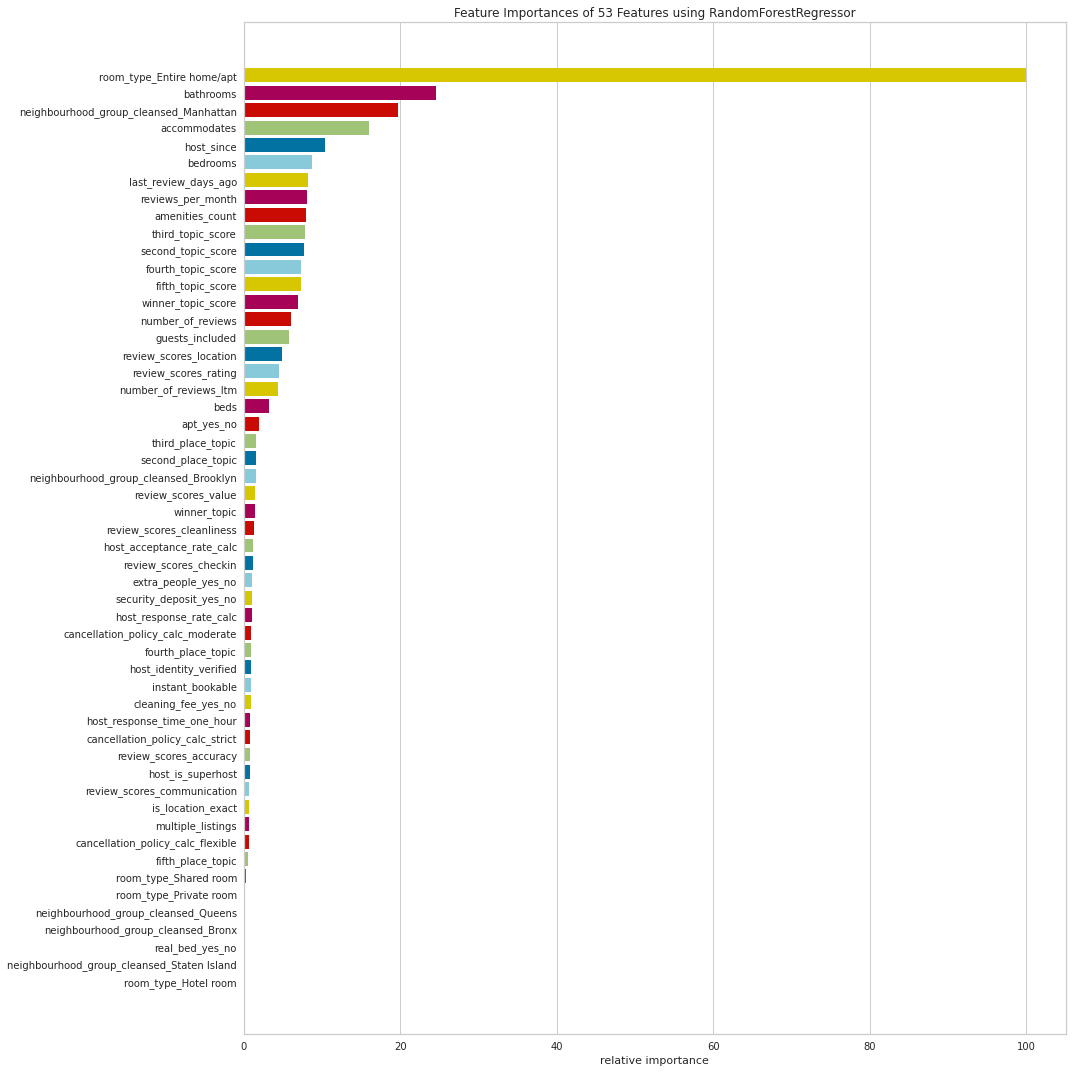

In [83]:
# Most important features
viz = FeatureImportances(regressors['random forest'], labels=features, size=(1080, 1080))
viz.fit(X_train, y_train)
viz.show()

### Creating a random variable 

As we can see in the feature importance graphic above we could conclude that the topics are part of the top features to determine price. To discard the fact that the impact of the scores is due to the fact that the values are numbers from a continuous distribution of numbers, we will create new column with random values from 0 to 1 and run the base regression again. In case this random doesn't appear as part of the next list of most relevant ones, we can be sure to discard this potential challenge

In [84]:
rand_var = list()
for i in range(X.shape[0]):
    rand_var.append(random.uniform(0, 1))

In [85]:
X['random cont variable'] = rand_var

In [86]:
X.shape

(5801, 54)

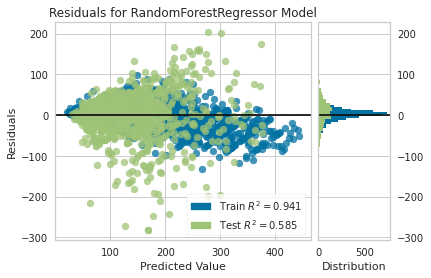

In [87]:
X_w_rand_train, X_w_rand_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_2 = ResidualsPlot(RandomForestRegressor())
visualizer_2.fit(X_w_rand_train, y_train)
visualizer_2.score(X_w_rand_test, y_test)
visualizer_2.show()

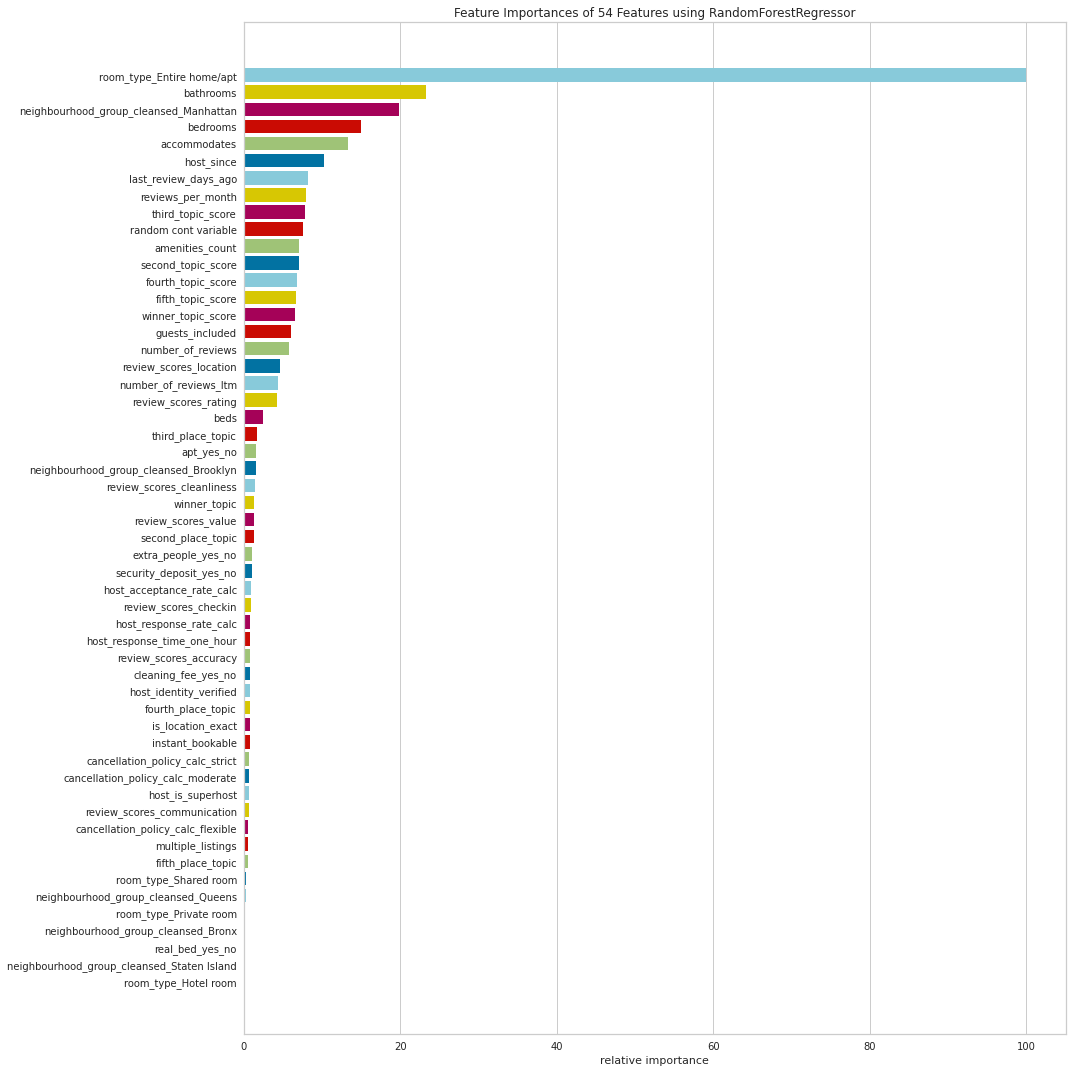

In [88]:
# Most important features
features_w_rand = features.append('random variable')
viz = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1080, 1080))
viz.fit(X_w_rand_train, y_train)
viz.show()

In [89]:
# X['neighbourhood_group_cleansed_Manhattan'].value_counts()
# X['neighbourhood_group_cleansed_Brooklyn'].value_counts()
# X['host_since'].value_counts()
# X['last_review_days_ago'].value_counts()

In [90]:
# X.columns

### Running the ensemble base model Random Forest removing room_type_Entire home/apt

In [91]:
X_not_prop_type = X.loc[:, X.columns != 'room_type_Entire home/apt']

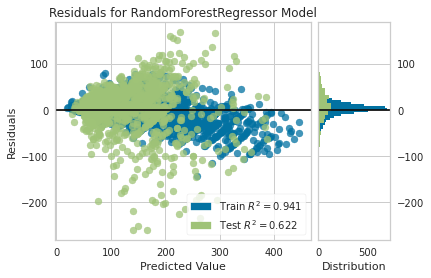

In [92]:
X_not_prop_type_train, X_not_prop_test, y_train, y_test = train_test_split(X_not_prop_type, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_3 = ResidualsPlot(RandomForestRegressor())
visualizer_3.fit(X_not_prop_type_train, y_train)
visualizer_3.score(X_not_prop_test, y_test)
visualizer_3.show()

In [93]:
# Most important features
features_not_property_typ = features.remove('room_type_Entire home/apt')

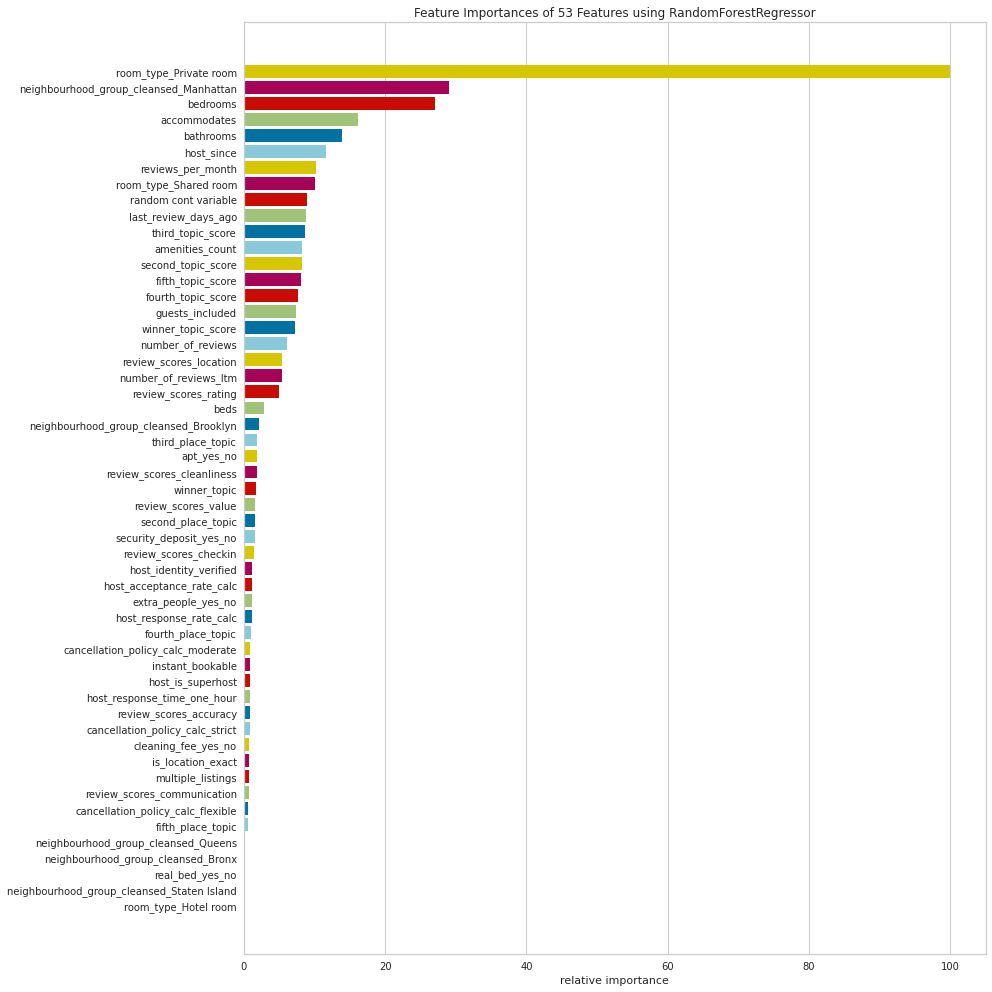

In [94]:
viz_3 = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1000, 1000))
viz_3.fit(X_not_prop_type_train, y_train)
viz_3.show()

### Determining linearity between room type entire home/apt

In [95]:
df_col = pd.DataFrame()
df_col['room type'] = X['room_type_Entire home/apt']
df_col['price'] = y

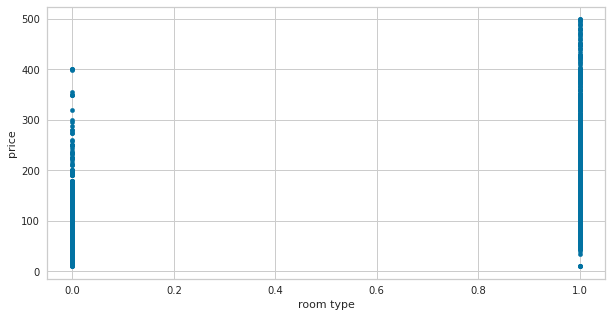

In [96]:
df_col.plot(kind='scatter', x='room type', y='price', figsize=(10,5), grid=True)
# X.plot(kind='scatter', x=X['room_type_Entire home/apt'], y=y, figsize=(10,5), grid=True)

In [97]:
# filepath = '5_text_analysis_name_desc.db'
# dill.dump_session()
# dill.load_session(filepath)